In [1]:
import sys
sys.path.append("..")


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score

from src.models.simple_transformer import SimpleTransformerClassifier


In [3]:
DATA_PATH = "../data/processed/"

train_df = pd.read_parquet(DATA_PATH + "train_cleaned.parquet")
valid_df = pd.read_parquet(DATA_PATH + "valid_cleaned.parquet")
test_df  = pd.read_parquet(DATA_PATH + "test_cleaned.parquet")

TEXT_COLUMN = "text_light"
LABEL_COLS = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

print(train_df.shape, valid_df.shape, test_df.shape)


(127656, 11) (15957, 9) (15958, 9)


In [ ]:
# --- Fast debug mode (set to 1.0 for full training) ---
SUBSAMPLE_FRAC ==1  # 10% for quick iteration; set to 1.0 later

train_df = train_df.sample(frac=SUBSAMPLE_FRAC, random_state=42)
valid_df = valid_df.sample(frac=SUBSAMPLE_FRAC, random_state=42)
test_df  = test_df.sample(frac=SUBSAMPLE_FRAC, random_state=42)

print("Subsampled sizes:", train_df.shape, valid_df.shape, test_df.shape)


Subsampled sizes: (127656, 11) (15957, 9) (15958, 9)


### Vocabulary Construction

The Transformer implemented from scratch requires token IDs as input.  
We therefore build a vocabulary from the training set using `CountVectorizer`.

Unlike the TF-IDF model, we only keep the dictionary mapping (token → index),  
not the TF-IDF weights.



In [5]:
vectorizer = CountVectorizer(max_features=20000)
vectorizer.fit(train_df[TEXT_COLUMN])

vocab = vectorizer.vocabulary_
vocab_size = len(vocab) + 1   # +1 pour padding index=0

print("Vocab size:", vocab_size)


Vocab size: 20001


### Tokenization and Sequence Encoding

Each comment is:
- tokenized,
- converted to token IDs using the vocabulary,
- truncated to a fixed maximum length `MAX_LEN`,
- padded with index 0 when shorter.

These token ID sequences are used as inputs to the Transformer.


In [6]:
MAX_LEN = 300

tokenizer = vectorizer.build_tokenizer()

def text_to_sequence(text):
    tokens = tokenizer(text.lower())
    ids = [vocab.get(tok, -1)+1 for tok in tokens[:MAX_LEN]]  # inconnus → 0
    if len(ids) < MAX_LEN:
        ids += [0] * (MAX_LEN - len(ids))
    return ids


### PyTorch Dataset

We define a `ToxicDataset` class compatible with PyTorch.

Each sample returns:
- `input_ids`: tokenized text sequence,
- `labels`: 6-dimensional toxicity label vector.

This format is used by the DataLoaders for training and evaluation.



In [7]:
class ToxicDataset(Dataset):
    def __init__(self, df):
        self.texts = df[TEXT_COLUMN].tolist()
        self.labels = df[LABEL_COLS].values.astype(np.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(text_to_sequence(self.texts[idx]), dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float32)
        }


### DataLoaders

DataLoaders enable:
- mini-batch training,
- shuffled training data,
- efficient iteration on CPU or GPU.


In [8]:
train_loader = DataLoader(ToxicDataset(train_df), batch_size=64, shuffle=True)
valid_loader = DataLoader(ToxicDataset(valid_df), batch_size=64)
test_loader  = DataLoader(ToxicDataset(test_df),  batch_size=64)


### Transformer Initialization

We instantiate the `SimpleTransformerClassifier` model:

- Token embedding + positional encoding  
- Multi-head self-attention blocks  
- Feed-forward layers with residual connections  
- Mean pooling over sequence  
- Linear classification layer for multi-label prediction  

The loss function is `BCEWithLogitsLoss`, suitable for multi-label classification.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = SimpleTransformerClassifier(
    vocab_size=vocab_size,
    num_labels=6,
    d_model=128,
    n_heads=4,
    num_layers=2,
    max_len=MAX_LEN
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


Device: cpu


### Evaluation Function

This section extends evaluation to match the Naive Bayes notebook metrics.

We compute:
- **Global multi-label metrics**: Macro F1, Micro F1, Exact-match Accuracy, Hamming Loss
- **Per-label metrics**: positive rate, precision, recall, F1 for each toxicity label
- **ROC/AUC per label**: using predicted probabilities (sigmoid outputs)

To do so, we first collect:
- `probs` of shape (N, 6) = sigmoid probabilities per label
- `y_true` of shape (N, 6) = ground-truth labels
Then we derive binary predictions with a fixed threshold (0.5 by default).


In [10]:
from sklearn.metrics import roc_auc_score

def predict_proba_and_labels(loader):
    """
    Returns:
      probs: (N, 6) sigmoid probabilities
      y_true: (N, 6) ground truth labels
    """
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            x = batch["input_ids"].to(device)
            y = batch["labels"].cpu().numpy()

            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()

            all_probs.append(probs)
            all_labels.append(y)

    probs = np.vstack(all_probs)
    y_true = np.vstack(all_labels)
    return probs, y_true


def compute_metrics(probs, y_true, threshold=0.5):
    preds = (probs >= threshold).astype(int)

    global_metrics = {
        "macro_f1": f1_score(y_true, preds, average="macro", zero_division=0),
        "micro_f1": f1_score(y_true, preds, average="micro", zero_division=0),
        "exact_accuracy": accuracy_score(y_true, preds),
        "hamming_loss": float(np.mean(preds != y_true))
    }

    rows = []
    for i, lab in enumerate(LABEL_COLS):
        y_i = y_true[:, i]
        p_i = preds[:, i]
        prob_i = probs[:, i]

        prec = ((p_i == 1) & (y_i == 1)).sum() / max((p_i == 1).sum(), 1)
        rec  = ((p_i == 1) & (y_i == 1)).sum() / max((y_i == 1).sum(), 1)
        f1   = f1_score(y_i, p_i, zero_division=0)

        try:
            auc_i = roc_auc_score(y_i, prob_i)
        except ValueError:
            auc_i = np.nan

        rows.append({
            "label": lab,
            "pos_rate": float(y_i.mean()),
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1),
            "roc_auc": float(auc_i) if not np.isnan(auc_i) else np.nan
        })

    per_label_df = pd.DataFrame(rows).sort_values("f1", ascending=False)
    return global_metrics, per_label_df


### Training the Transformer

The model is trained for several epochs:

- forward pass  
- loss computation  
- backpropagation  
- weight updates  

After each epoch, performance is evaluated on the validation set.


274min 

In [11]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    
    for batch in train_loader:
        x = batch["input_ids"].to(device)
        y = batch["labels"].to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
    
    val_probs, val_y = predict_proba_and_labels(valid_loader)
    val_g, val_pl = compute_metrics(val_probs, val_y, threshold=0.5)

    print(
        f"Epoch {epoch+1} | "
        f"Val Acc: {val_g['exact_accuracy']:.4f} | "
        f"F1 macro: {val_g['macro_f1']:.4f} | "
        f"F1 micro: {val_g['micro_f1']:.4f}"
    )


Epoch 1 | Val Acc: 0.9193 | F1 macro: 0.4544 | F1 micro: 0.7058
Epoch 2 | Val Acc: 0.9198 | F1 macro: 0.5311 | F1 micro: 0.7277
Epoch 3 | Val Acc: 0.9173 | F1 macro: 0.5798 | F1 micro: 0.7287
Epoch 4 | Val Acc: 0.9210 | F1 macro: 0.5438 | F1 micro: 0.7406
Epoch 5 | Val Acc: 0.9190 | F1 macro: 0.5714 | F1 micro: 0.7377


In [12]:
def report_split(name, loader, threshold=0.5):
    probs, y_true = predict_proba_and_labels(loader)
    global_metrics, per_label = compute_metrics(probs, y_true, threshold=threshold)

    print(f"\n===== {name.upper()} GLOBAL METRICS =====")
    display(pd.DataFrame([{"split": name, **global_metrics}]))

    print(f"\n===== {name.upper()} PER-LABEL METRICS =====")
    display(per_label)

    return probs, y_true, global_metrics, per_label

train_probs, train_y, train_g, train_pl = report_split("train", train_loader, threshold=0.5)
val_probs, val_y, val_g, val_pl       = report_split("valid", valid_loader, threshold=0.5)
test_probs, test_y, test_g, test_pl   = report_split("test",  test_loader,  threshold=0.5)



===== TRAIN GLOBAL METRICS =====


,split,macro_f1,micro_f1,exact_accuracy,hamming_loss
0,train,0.635895,0.788457,0.928597,0.01494



===== TRAIN PER-LABEL METRICS =====


,label,pos_rate,precision,recall,f1,roc_auc
2,obscene,0.053057,0.873615,0.826665,0.849492,0.993834
0,toxic,0.096165,0.854122,0.809384,0.831151,0.983964
4,insult,0.049406,0.776825,0.732361,0.753938,0.988052
5,identity_hate,0.008907,0.718702,0.408971,0.521300,0.988083
1,severe_toxic,0.010152,0.557924,0.464506,0.506947,0.990965
3,threat,0.003063,0.522613,0.265985,0.352542,0.987291



===== VALID GLOBAL METRICS =====


,split,macro_f1,micro_f1,exact_accuracy,hamming_loss
0,valid,0.571399,0.737692,0.91897,0.017975



===== VALID PER-LABEL METRICS =====


,label,pos_rate,precision,recall,f1,roc_auc
2,obscene,0.053331,0.842105,0.789659,0.815039,0.986272
0,toxic,0.092373,0.797542,0.748304,0.772139,0.967272
4,insult,0.048944,0.741259,0.678617,0.708556,0.978332
1,severe_toxic,0.009087,0.457746,0.448276,0.452962,0.990768
5,identity_hate,0.008272,0.579710,0.303030,0.398010,0.969557
3,threat,0.002820,0.384615,0.222222,0.281690,0.959742



===== TEST GLOBAL METRICS =====


,split,macro_f1,micro_f1,exact_accuracy,hamming_loss
0,test,0.566771,0.722356,0.91158,0.019196



===== TEST PER-LABEL METRICS =====


,label,pos_rate,precision,recall,f1,roc_auc
2,obscene,0.051698,0.826649,0.774545,0.799750,0.987845
0,toxic,0.096754,0.791989,0.729922,0.759690,0.963219
4,insult,0.049442,0.724187,0.648923,0.684492,0.975198
5,identity_hate,0.008522,0.662338,0.375000,0.478873,0.974183
1,severe_toxic,0.009650,0.425000,0.331169,0.372263,0.984784
3,threat,0.002632,0.366667,0.261905,0.305556,0.980108


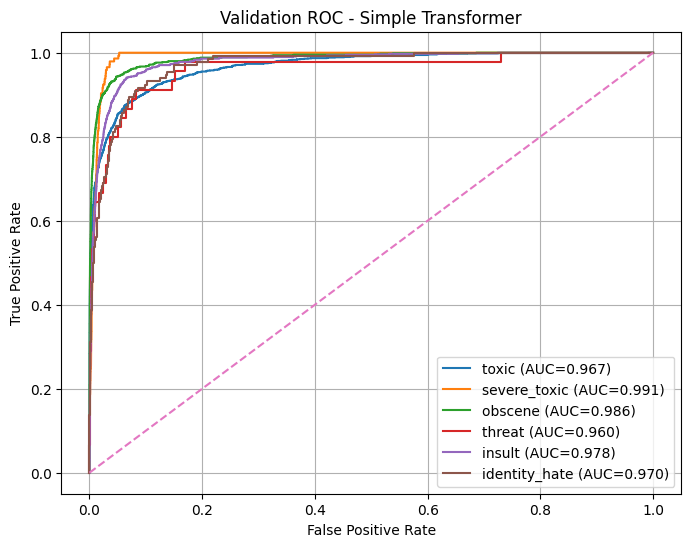

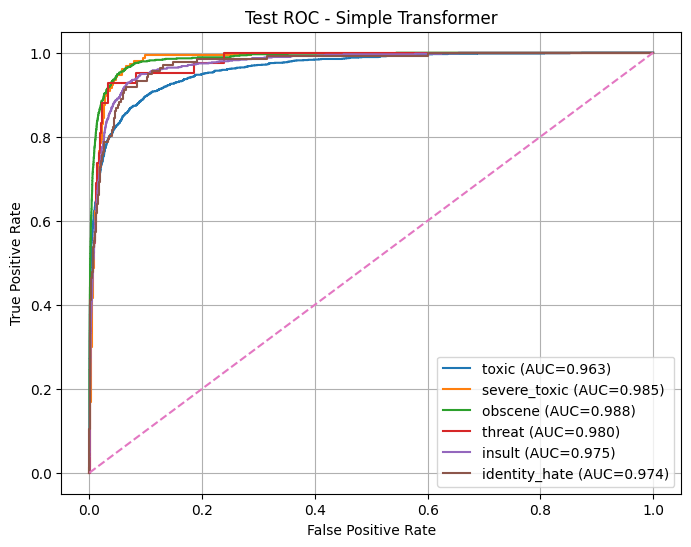

ROC figures saved in reports/figures/


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(probs, y_true, title="ROC Curves", save_path=None):
    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(LABEL_COLS):
        y_i = y_true[:, i]
        prob_i = probs[:, i]

        if len(np.unique(y_i)) < 2:
            continue

        fpr, tpr, _ = roc_curve(y_i, prob_i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{lab} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()  
    plt.close()
    
        


plot_roc_curves(
    val_probs, val_y,
    title="Validation ROC - Simple Transformer",
    save_path="../reports/figures/roc_validation_simple_transformer.png"
)

plot_roc_curves(
    test_probs, test_y,
    title="Test ROC - Simple Transformer",
    save_path="../reports/figures/roc_test_simple_transformer.png"
)

print("ROC figures saved in reports/figures/")



In [ ]:
# ===== Save trained model =====

#MODEL_SAVE_PATH = "../models/simple_transformer.pth"

#torch.save({
    #"model_state_dict": model.state_dict(),
    #"vocab": vocab,
    #"max_len": MAX_LEN
#}, MODEL_SAVE_PATH)

#print("Model saved to:", MODEL_SAVE_PATH)


Model saved to: ../models/simple_transformer.pth


In [ ]:
#checkpoint = torch.load("../models/simple_transformer.pth", map_location=device)

#model = SimpleTransformerClassifier(
    #vocab_size=len(checkpoint["vocab"]) + 1,
    #num_labels=6,
    #max_len=checkpoint["max_len"]
#).to(device)

#model.load_state_dict(checkpoint["model_state_dict"])
#model.eval()


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

### Saving the Trained Model

To avoid re-training the Transformer every time, we save the trained model to disk.

Due to recent PyTorch security changes (default `weights_only=True` in `torch.load`), 
saving arbitrary Python objects inside `torch.save` can cause unpickling errors.  
Therefore, we store:

- Model weights only (`state_dict`) in a `.pth` file  
- Vocabulary as a plain JSON dictionary  
- Meta-information (e.g. `max_len`) as a JSON file  

This ensures safe and portable model reloading.


In [17]:
import json

MODEL_PATH = "../models/simple_transformer_state_dict.pth"
VOCAB_PATH = "../models/simple_transformer_vocab.json"
META_PATH  = "../models/simple_transformer_meta.json"

# 1) Save weights only (safe)
torch.save(model.state_dict(), MODEL_PATH)

# 2) Save vocab as JSON (convert to plain dict[str,int])
with open(VOCAB_PATH, "w", encoding="utf-8") as f:
    json.dump({k: int(v) for k, v in vocab.items()}, f)

# 3) Save meta
with open(META_PATH, "w", encoding="utf-8") as f:
    json.dump({"max_len": int(MAX_LEN)}, f)

print("Saved:")
print(" -", MODEL_PATH)
print(" -", VOCAB_PATH)
print(" -", META_PATH)


Saved:
 - ../models/simple_transformer_state_dict.pth
 - ../models/simple_transformer_vocab.json
 - ../models/simple_transformer_meta.json


### Reloading the Saved Model

To reuse the trained Transformer without retraining:

- Load the vocabulary from JSON  
- Load model hyperparameters from meta file  
- Rebuild the model architecture  
- Load the saved `state_dict` weights  

This guarantees full reproducibility of predictions and evaluation.


In [18]:
import json

MODEL_PATH = "../models/simple_transformer_state_dict.pth"
VOCAB_PATH = "../models/simple_transformer_vocab.json"
META_PATH  = "../models/simple_transformer_meta.json"

with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    vocab_loaded = json.load(f)  # dict token->id

with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)

max_len_loaded = meta["max_len"]
vocab_size_loaded = len(vocab_loaded) + 1

model = SimpleTransformerClassifier(
    vocab_size=vocab_size_loaded,
    num_labels=6,
    max_len=max_len_loaded
).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)  # weights_only ok
model.load_state_dict(state_dict)
model.eval()

print("Model loaded successfully.")


Model loaded successfully.
